# Project description
The current project aims to predict the genre of movie given the overview text that describes the movie. For example, the overview for *The Matrix* is as follows:
>Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.

From the above text, we would like to predict that the movie belongs to the "Action" and "Science Fiction" genres.

## Business object in context
We are an internet-based movie distributing company, _NetFlux_. For new movies and original content movies, we want to make sure our staff writes overviews that will represent the correct genre of the movie. This will make our recommender system work better and ultimately provide more insight for our users to what movies they want to see.



In [10]:
from IPython.display import Markdown as md
import os
from datetime import datetime
import pickle 

movies_with_overviews_path = '../data/interim/movies_with_overviews.pkl'
date_refreshed_unix = os.path.getmtime(movies_with_overviews_path)
date_refreshed = datetime.utcfromtimestamp(date_refreshed_unix).strftime('%Y-%m-%d %H:%M:%S')
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

with open(movies_with_overviews_path,'rb') as f:
    movies_with_overviews=pickle.load(f)
with open('../data/processed/genre_id_to_name_dict.pkl','rb') as f:
    Genre_ID_to_name=pickle.load(f)
genre_list=sorted(list(Genre_ID_to_name.keys()))
    
num_movies = len(movies_with_overviews)

display(md('''# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **{date_refreshed}**.

Report was generated **{now}**.

The data have **{num_movies}** movie overviews.

'''.format(date_refreshed=date_refreshed, num_movies=num_movies, now=now)))


# Data
Movie overviews and genres are scraped from TMDB. Our dataset was last refreshed at **2020-10-28 02:05:38**.

Report was generated **2020-10-27 19:18:59**.

The data have **1743** movie overviews.



The distribution of the genres in these movies is shown in the chart below:

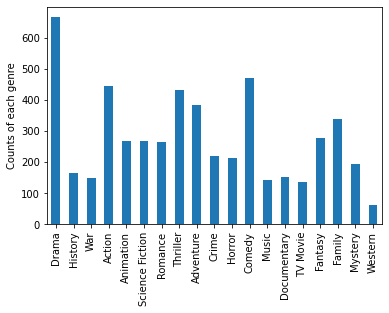

In [11]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
mwo = pd.DataFrame(movies_with_overviews)
genre_ids_series = mwo['genre_ids']
flat_genre_ids = [st for row in genre_ids_series for st in row]

flat_genre_names = [Genre_ID_to_name[id] for id in flat_genre_ids] 
genre_counts = Counter(flat_genre_names)
df = pd.DataFrame.from_dict(genre_counts, orient='index')
ax = df.plot(kind='bar')
ax.set_ylabel('Counts of each genre')
ax.legend().set_visible(False)


The top 10 movies in our dataset by popularity are listed below:

In [12]:
a=[print(x) for x in mwo.sort_values(by='popularity', ascending=False)['original_title'].head(10)]

Вий
Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan
Haute tension
呪怨2
Road to Ninja: Naruto the Movie
Hacksaw Ridge
Frozen
Coraline
Big Hero 6
Whiteout


# Models and Features

We are currently using the following models to train against the dataset with the associated feature engineering:
1. C-SVM
    - The overviews are using a **bag of words** model and have been vectorized and transformed using **TF_IDF**.
2. Naive Bayes
    - The overviews are using a **bag of words** model and have been vectorized with a **Count Vectorizer**.
3. Simple neural network (not deep)
    - The overviews were tokenized with a **white space tokenizer**. Stop words were removed. Overviews were treated as **bag of words**, which each word being converted to a vector, using the GoogleNews-vectors-negative300.bin model.  The **arithmetic mean** of the words represented the overview. Taking the top 3 genres predicted for each movie.



### C-SVM

#### Metrics for each genre

In [13]:
with open('../models/classifier_svc.pkl','rb') as f:
    classif=pickle.load(f)
with open('../data/processed/X_tfidf.pkl','rb') as f:
    X=pickle.load(f)
with open('../data/processed/Y.pkl','rb') as f:
    Y=pickle.load(f)
    
from src.utils.eval_metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
predstfidf=classif.predict(X_test)
print (classification_report(Y_test, predstfidf, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.20      1.00      0.34        71
      Adventure       0.49      0.57      0.52        65
      Animation       0.40      0.55      0.46        53
         Comedy       0.56      0.58      0.57       133
          Crime       0.00      0.00      0.00        48
    Documentary       0.56      0.69      0.62        87
          Drama       0.43      0.65      0.52        92
         Family       0.38      0.44      0.41        34
        Fantasy       0.38      0.38      0.38        13
        History       0.54      0.60      0.56        89
         Horror       0.49      0.52      0.50        52
          Music       0.56      0.52      0.54        29
        Mystery       0.51      0.40      0.45        45
        Romance       0.39      0.51      0.44        41
Science Fiction       0.50      0.62      0.55        26
       TV Movie       0.42      0.50      0.45        44
       Thriller       0.58    

/Users/joshuabroomberg/work/Domino/ml-ci/prototyping/MovieGenrePrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Precision and Recall for the overall model

In [14]:
predictions = generate_predictions(Genre_ID_to_name, X_test, predstfidf)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.40582617000955107

Recall: 0.5633169600218311



#### Example predictions for a small sample

In [15]:
predictions=[]
actuals = []
for i in range(X_test.shape[0]):
    pred_genres=[]
    actual_genres=[]
    movie_label_scores=predstfidf[i]
    actual_scores = Y_test[i]
#     print movie_label_scores
    for j in range(len(movie_label_scores)):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
        if actual_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            actual_genres.append(genre)
    predictions.append(pred_genres)
    actuals.append(actual_genres)
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  Honeymoon for One 
PREDICTION:  Adventure,Drama,Comedy,Mystery,Romance 
Actual:  Comedy,Romance,TV Movie 

MOVIE:  Little Children 
PREDICTION:  Adventure,Thriller 
Actual:  Drama,Comedy,Romance 

MOVIE:  Secrets of War 
PREDICTION:  Adventure,Comedy,History,Crime 
Actual:  Drama,History,Family,War 

MOVIE:  The Grey 
PREDICTION:  Adventure,TV Movie 
Actual:  Adventure,Drama,Action,Thriller 

MOVIE:  Jeepers Creepers 
PREDICTION:  Adventure,Comedy,Family 
Actual:  Horror,Thriller 

MOVIE:  Pokémon the Movie: Hoopa and the Clash of Ages 
PREDICTION:  Adventure,Action,Comedy,Science Fiction 
Actual:  Adventure,Fantasy,Animation,Action,Family 



### Naive Bayes

#### Metrics for each genre

In [16]:
with open('../models/classifier_nb.pkl','rb') as f:
    classif=pickle.load(f)
with open('../data/processed/X.pkl','rb') as f:
    X=pickle.load(f)
with open('../data/processed/Y.pkl','rb') as f:
    Y=pickle.load(f)
    
from src.utils.eval_metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
preds=classif.predict(X_test)
print (classification_report(Y_test, preds, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.48      0.49      0.49        71
      Adventure       0.70      0.60      0.64        65
      Animation       0.49      0.49      0.49        53
         Comedy       0.56      0.57      0.57       133
          Crime       0.45      0.42      0.43        48
    Documentary       0.61      0.69      0.65        87
          Drama       0.56      0.62      0.59        92
         Family       0.41      0.50      0.45        34
        Fantasy       0.17      0.08      0.11        13
        History       0.69      0.65      0.67        89
         Horror       0.62      0.54      0.58        52
          Music       0.47      0.66      0.55        29
        Mystery       0.45      0.49      0.47        45
        Romance       0.52      0.34      0.41        41
Science Fiction       0.56      0.69      0.62        26
       TV Movie       0.38      0.57      0.46        44
       Thriller       0.59    

/Users/joshuabroomberg/work/Domino/ml-ci/prototyping/MovieGenrePrediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Precision and Recall for the overall model

In [17]:
predictions = generate_predictions(Genre_ID_to_name, X_test, preds)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.5238334015554645

Recall: 0.5660390230590804



#### Example predictions for a small sample

In [18]:
predictions=[]
actuals = []
for i in range(X_test.shape[0]):
    pred_genres=[]
    actual_genres=[]
    movie_label_scores=preds[i]
    actual_scores = Y_test[i]
#     print movie_label_scores
    for j in range(len(movie_label_scores)):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
        if actual_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            actual_genres.append(genre)
    predictions.append(pred_genres)
    actuals.append(actual_genres)
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  Honeymoon for One 
PREDICTION:  Drama,Horror,Comedy,Mystery,Romance,Family,TV Movie 
Actual:  Comedy,Romance,TV Movie 

MOVIE:  Little Children 
PREDICTION:  Drama 
Actual:  Drama,Comedy,Romance 

MOVIE:  Secrets of War 
PREDICTION:  Comedy 
Actual:  Drama,History,Family,War 

MOVIE:  The Grey 
PREDICTION:   
Actual:  Adventure,Drama,Action,Thriller 

MOVIE:  Jeepers Creepers 
PREDICTION:  Horror,Comedy,Family 
Actual:  Horror,Thriller 

MOVIE:  Pokémon the Movie: Hoopa and the Clash of Ages 
PREDICTION:  Fantasy,Horror,Action,Science Fiction 
Actual:  Adventure,Fantasy,Animation,Action,Family 



In [19]:
print(movies_with_overviews[test_movies[100]])
print(Genre_ID_to_name[35])
print(Genre_ID_to_name[10751])
test_movies[100]
classif.predict(X_test[100])

{'popularity': 13.019, 'id': 1440, 'video': False, 'vote_count': 578, 'vote_average': 7.2, 'title': 'Little Children', 'release_date': '2006-10-06', 'original_language': 'en', 'original_title': 'Little Children', 'genre_ids': [10749, 18, 35], 'backdrop_path': '/lHAYacdv2ldnr9GZO5hymTK5rFc.jpg', 'adult': False, 'overview': 'The lives of two lovelorn spouses from separate marriages, a registered sex offender, and a disgraced ex-police officer intersect as they struggle to resist their vulnerabilities and temptations.', 'poster_path': '/so9xla7b7WfFiarDwOukhQpRuyd.jpg'}
Comedy
Family


array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Simple Neural Network with Word2Vec features

#### Metrics for each genre

In [20]:
from keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
with open('../data/processed/textual_features.pkl','rb') as f:
    (X,Y)=pickle.load(f)
model_textual = load_model('../models/overview_nn.h5')

indecies = range(len(movies_with_overviews))
X_train, X_test, Y_train, Y_test, train_movies, test_movies = train_test_split(X, Y, indecies, test_size=0.20, random_state=42)
genre_names=list(Genre_ID_to_name.values())
Y_preds=model_textual.predict(X_test)

Y_preds_binary = []
for row in Y_preds:
    predicted = np.argsort(row)[::-1][:3]
    predicted_genre_Y = [1 if k in predicted else 0 for k in range(len(row)) ]
    Y_preds_binary.append(predicted_genre_Y)

print (classification_report(Y_test, np.array(Y_preds_binary), target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.62      0.49      0.55        71
      Adventure       0.43      0.35      0.39        65
      Animation       0.52      0.53      0.52        53
         Comedy       0.55      0.61      0.58       133
          Crime       0.60      0.54      0.57        48
    Documentary       0.61      0.62      0.61        87
          Drama       0.48      0.63      0.54        92
         Family       0.31      0.29      0.30        34
        Fantasy       0.67      0.31      0.42        13
        History       0.55      0.58      0.57        89
         Horror       0.70      0.44      0.54        52
          Music       0.53      0.69      0.60        29
        Mystery       0.45      0.40      0.42        45
        Romance       0.44      0.41      0.43        41
Science Fiction       0.69      0.85      0.76        26
       TV Movie       0.40      0.43      0.42        44
       Thriller       0.61    

#### Precision and Recall for the overall model

In [21]:
predictions = generate_predictions(Genre_ID_to_name, X_test, Y_preds_binary)
precs, recs = precsc_recs(test_movies, movies_with_overviews, Genre_ID_to_name, predictions)

prec_mean = np.mean(np.asarray(precs))
rec_mean = np.mean(np.asarray(recs))

md('''Precision: {prec_mean}

Recall: {rec_mean}

'''.format(prec_mean=prec_mean, rec_mean=rec_mean))

Precision: 0.5310410697230181

Recall: 0.5530904625460499



#### Example predictions for a small sample

In [22]:
for i in range(X_test.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[test_movies[i]]['title'],
               '\nPREDICTION: ',','.join(predictions[i]), 
               '\nActual: ', ','.join(actuals[i]), '\n')

MOVIE:  Honeymoon for One 
PREDICTION:  Drama,Comedy,Romance 
Actual:  Comedy,Romance,TV Movie 

MOVIE:  Little Children 
PREDICTION:  Drama,Thriller,Romance 
Actual:  Drama,Comedy,Romance 

MOVIE:  Secrets of War 
PREDICTION:  Animation,Action,Family 
Actual:  Drama,History,Family,War 

MOVIE:  The Grey 
PREDICTION:  Adventure,Fantasy,Science Fiction 
Actual:  Adventure,Drama,Action,Thriller 

MOVIE:  Jeepers Creepers 
PREDICTION:  Horror,Comedy,Family 
Actual:  Horror,Thriller 

MOVIE:  Pokémon the Movie: Hoopa and the Clash of Ages 
PREDICTION:  Adventure,Animation,Action 
Actual:  Adventure,Fantasy,Animation,Action,Family 



In [23]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../notebooks/static/custom.css", "r").read()
    return HTML(styles)
css_styling()